# Setup

**Importing libraries**

In [1]:
import gc
gc.enable()

import warnings
warnings.filterwarnings(category=FutureWarning, action='ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split

**Raw dataset**

In [2]:
DATA_DIR = '../Dataset'
df = pd.read_csv(f'{DATA_DIR}/ai4i2020.csv')

# Data overview

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

* 10000 rows
* 14 columns - 1 target, 5 auxillary targets, 8 features
* No missing values (logically missing values such as '?' or '-' to be checked)

In [4]:
df.describe(include='all')

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
unique,NaN,10000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,M14860,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,NaN,NaN,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,NaN,NaN,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,NaN,NaN,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,NaN,NaN,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,NaN,NaN,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,NaN,NaN,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


### Target column

In [5]:
TARGET = 'Machine failure'

In [6]:
df[TARGET].value_counts()

Machine failure
0    9661
1     339
Name: count, dtype: int64

Extremely imbalanced target. Machine failure is a very rare occurance compared to the alternative.  

Possible approaches for handling the imbalance:
* Over/Under-sampling (not recommended, since it changes the nature of the problem)
* Balancing sample-weights in algorithms which allow it (e.g. XGBoost 'scale_pos_weight').
* Predicting probabilities and using thresholding techniques to find the ideal balance.
* Trying anomaly-detection algorithms (e.g. Isolation Forest).

Another factor is our metric for this problem. Accuracy is not suitable due to the heavy imbalance.  
It is important for us to **identify all instances of machine failure**, at the cost of having some false positives,  
since we must avoid machine failure at all costs. Hence, we must focus on maximising **recall**.

In [7]:
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

In [8]:
for col in failure_types:
    print(df[col].value_counts().rename(f'{col} counts'))

TWF
0    9954
1      46
Name: TWF counts, dtype: int64
HDF
0    9885
1     115
Name: HDF counts, dtype: int64
PWF
0    9905
1      95
Name: PWF counts, dtype: int64
OSF
0    9902
1      98
Name: OSF counts, dtype: int64
RNF
0    9981
1      19
Name: RNF counts, dtype: int64


"Machine failure" will be the primary target while the failure types can be used for feature engineering based on domain knowledge.

# Feature exploration

In [9]:
features = list(df.columns)[:8]

### Feature types (based on number of unique values)

In [10]:
df[features].nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
dtype: int64

* One categorical feature: *Type*
* Remaining are numerical, out of which two may be unique identifiers, which means they are not features.

### UDI

In [11]:
df['UDI'].nunique(), df['UDI'].min(), df['UDI'].max()

(10000, 1, 10000)

UDI is definitely a unique identifier. We can drop it from our feature set.

### Product ID

In [12]:
df['Product ID'].unique()[:10]

array(['M14860', 'L47181', 'L47182', 'L47183', 'L47184', 'M14865',
       'L47186', 'L47187', 'M14868', 'M14869'], dtype=object)

In [13]:
# dropping first letter in each ID, which is the same as Type
df['Product ID'] = df['Product ID'].apply(lambda x: str(x)[1:])

In [14]:
df['Product ID'].nunique()

10000

We still have all unique values after removing the Type. We can drop this column from our feature set.

### Type

In [15]:
df['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

From the dataset description, these are equivalent to Low, Medium and High quality variants.  
Number of machines decrease with improvement in quality.

In [16]:
df.groupby('Type')[TARGET].value_counts(normalize=True)

Type  Machine failure
H     0                  0.979063
      1                  0.020937
L     0                  0.960833
      1                  0.039167
M     0                  0.972306
      1                  0.027694
Name: proportion, dtype: float64

As expected, percentage of failures is lower for higher quality variants.  
This also confirms that we can proceed with an ordinal mapping for this categorical column.

In [17]:
type_mapping = {'L': 0, 'M': 1, 'H': 2}
df['Type'] = df['Type'].replace(type_mapping)

### Air temperature [K]

In [18]:
df['Air temperature [K]'].describe()

count    10000.000000
mean       300.004930
std          2.000259
min        295.300000
25%        298.300000
50%        300.100000
75%        301.500000
max        304.500000
Name: Air temperature [K], dtype: float64

We can convert from Kelvin to Celsius since it only changes the scale of the data.

In [19]:
df['air_temp_celsius'] = df['Air temperature [K]'] - 273.15
df = df.drop('Air temperature [K]', axis=1)

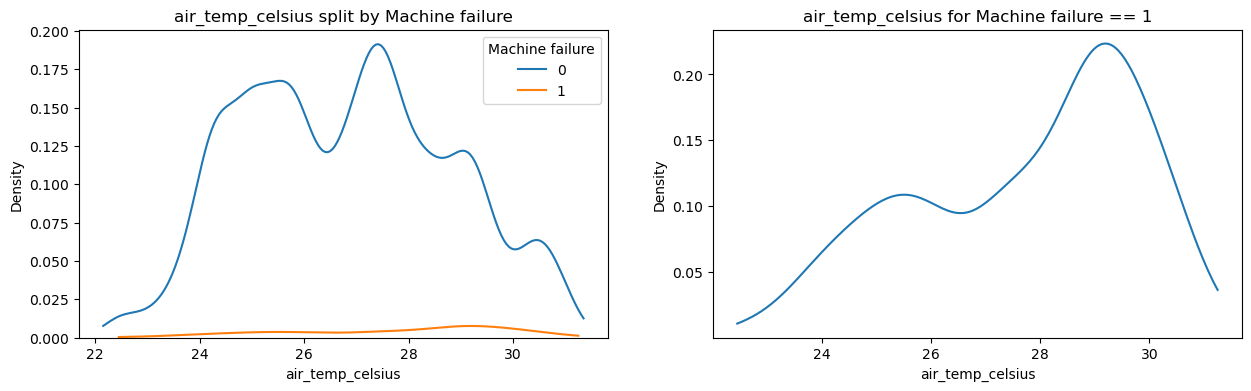

In [20]:
def plot_numerical(f, split_col=TARGET):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    ax[0].set_title(f"{f} split by {split_col}")
    sns.kdeplot(x=f, data=df, hue=split_col, cut=0, ax=ax[0])
    ax[1].set_title(f"{f} for {split_col} == 1")
    sns.kdeplot(x=f, data=df[df[split_col]==1], cut=0, ax=ax[1])
    plt.show()

plot_numerical('air_temp_celsius')

### Process temperature [K]

In [21]:
df['Process temperature [K]'].describe()

count    10000.000000
mean       310.005560
std          1.483734
min        305.700000
25%        308.800000
50%        310.100000
75%        311.100000
max        313.800000
Name: Process temperature [K], dtype: float64

Higher values compared to air temperature.

In [22]:
df['process_temp_celsius'] = df['Process temperature [K]'] - 273.15
df = df.drop('Process temperature [K]', axis=1)

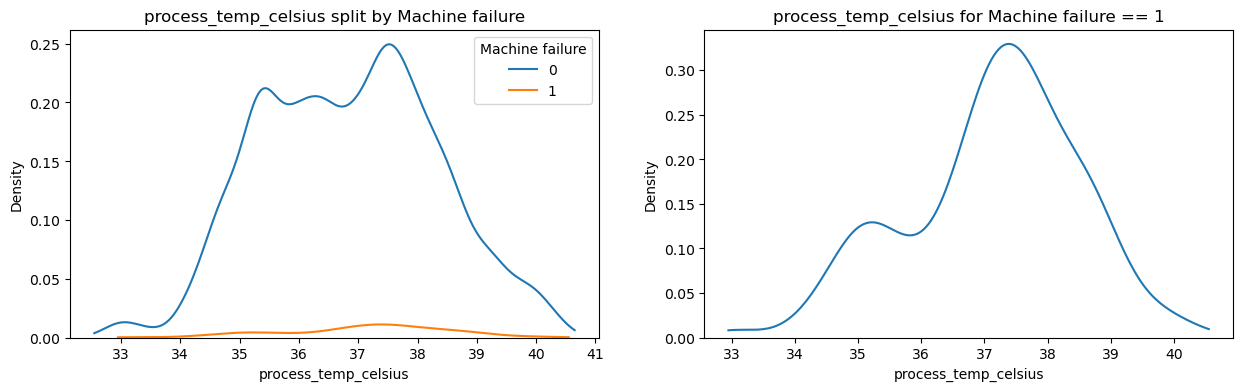

In [23]:
plot_numerical('process_temp_celsius')

### Rotational speed [rpm]

In [24]:
df['Rotational speed [rpm]'].describe()

count    10000.000000
mean      1538.776100
std        179.284096
min       1168.000000
25%       1423.000000
50%       1503.000000
75%       1612.000000
max       2886.000000
Name: Rotational speed [rpm], dtype: float64

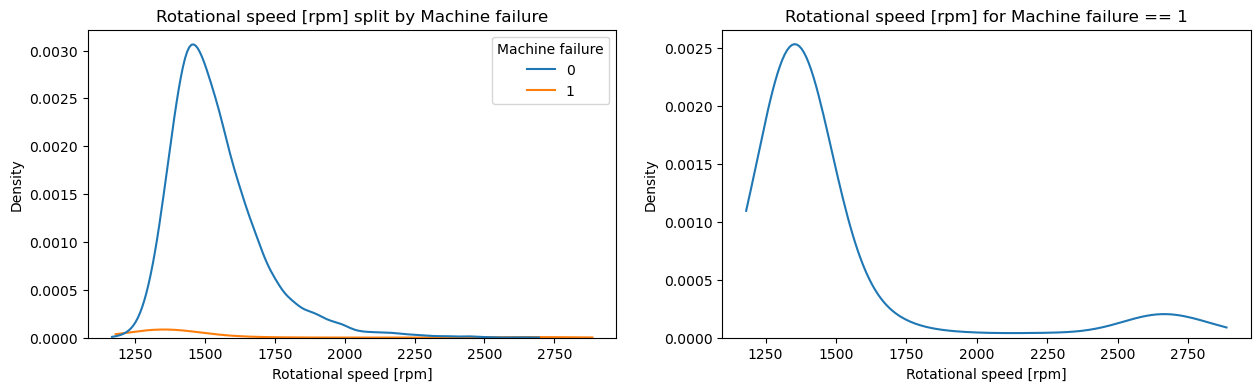

In [25]:
plot_numerical('Rotational speed [rpm]')

### Torque [Nm]

In [26]:
df['Torque [Nm]'].describe()

count    10000.000000
mean        39.986910
std          9.968934
min          3.800000
25%         33.200000
50%         40.100000
75%         46.800000
max         76.600000
Name: Torque [Nm], dtype: float64

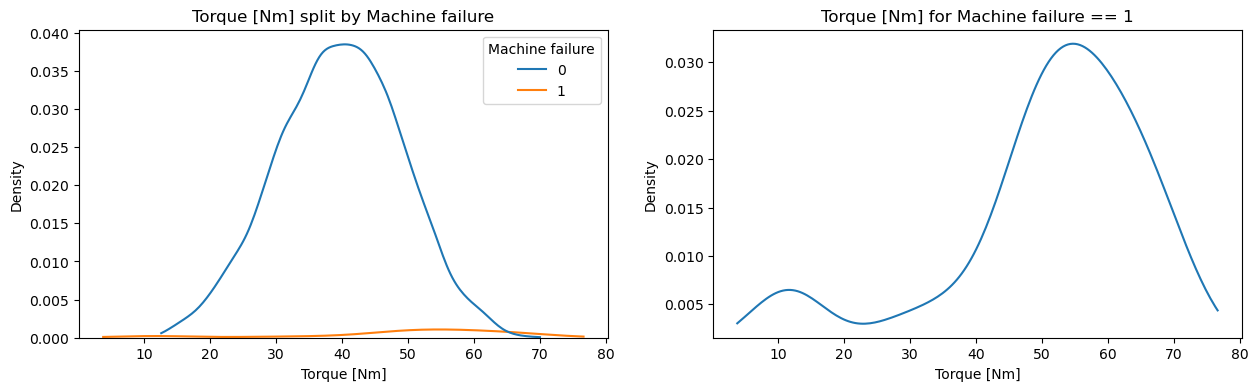

In [27]:
plot_numerical('Torque [Nm]')

### Tool wear [min]

In [28]:
df['Tool wear [min]'].describe()

count    10000.000000
mean       107.951000
std         63.654147
min          0.000000
25%         53.000000
50%        108.000000
75%        162.000000
max        253.000000
Name: Tool wear [min], dtype: float64

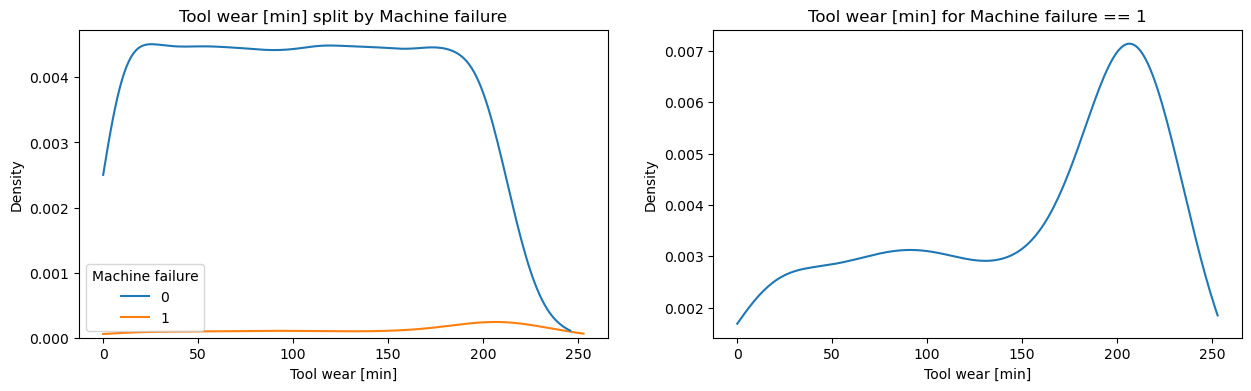

In [29]:
plot_numerical('Tool wear [min]')

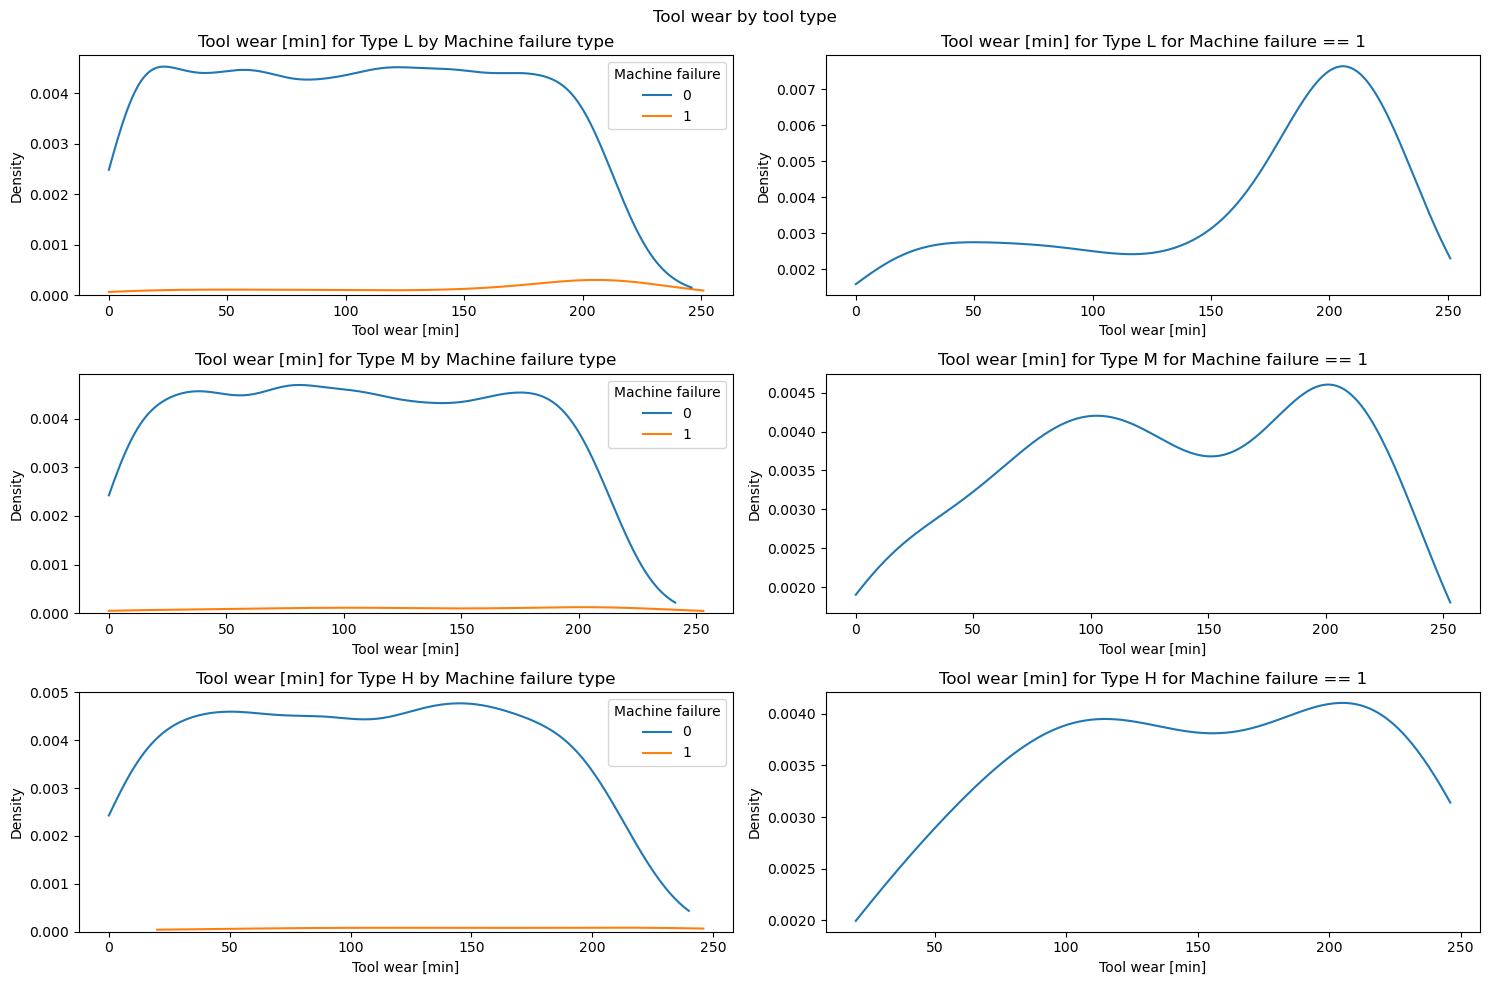

In [30]:
f = 'Tool wear [min]'
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
plt.suptitle('Tool wear by tool type')
ax[0][0].set_title(f"{f} for Type L by Machine failure type")
sns.kdeplot(x=f, data=df[df.Type==0], hue=TARGET, cut=0, ax=ax[0][0])
ax[0][1].set_title(f"{f} for Type L for Machine failure == 1")
sns.kdeplot(x=f, data=df[(df.Type==0) & (df[TARGET]==1)], cut=0, ax=ax[0][1])
ax[1][0].set_title(f"{f} for Type M by Machine failure type")
sns.kdeplot(x=f, data=df[df.Type==1], hue=TARGET, cut=0, ax=ax[1][0])
ax[1][1].set_title(f"{f} for Type M for Machine failure == 1")
sns.kdeplot(x=f, data=df[(df.Type==1) & (df[TARGET]==1)], cut=0, ax=ax[1][1])
ax[2][0].set_title(f"{f} for Type H by Machine failure type")
sns.kdeplot(x=f, data=df[df.Type==2], hue=TARGET, cut=0, ax=ax[2][0])
ax[2][1].set_title(f"{f} for Type H for Machine failure == 1")
sns.kdeplot(x=f, data=df[(df.Type==2) & (df[TARGET]==1)], cut=0, ax=ax[2][1])
fig.tight_layout()
plt.show()

# Feature engineering

### Cause of Heat Dissipation Failure

In [31]:
df['HDF'].value_counts()

HDF
0    9885
1     115
Name: count, dtype: int64

If heat is not dissipating, air temperature and process temperature will be closer in magnitude.

In [32]:
df['temp_diff'] = df['process_temp_celsius'] - df['air_temp_celsius']

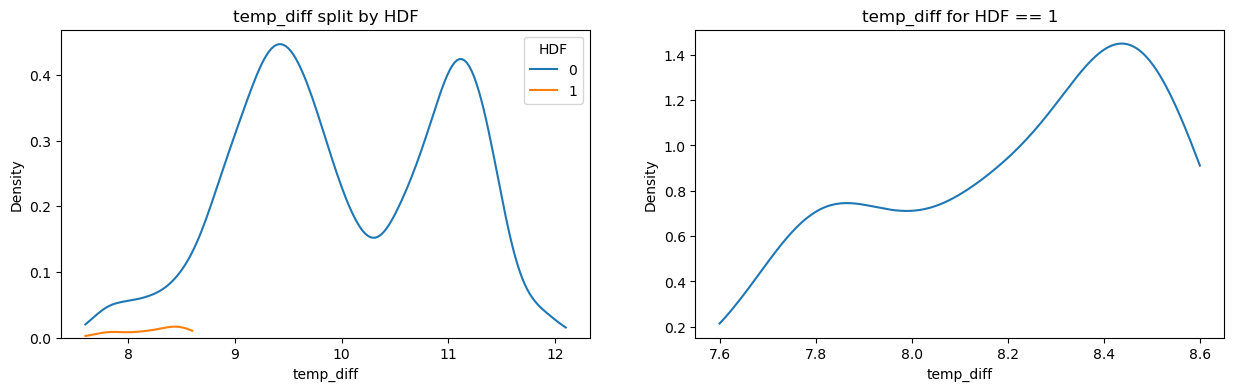

In [33]:
plot_numerical('temp_diff', split_col='HDF')

* Above a certain threshold, machine is never failing due to HDF.
* Ideal threshold is between 8 and 9

In [34]:
len(df.query("HDF == 1 and temp_diff < 8.5")), len(df.query("HDF == 1 and temp_diff < 8.6")), len(df.query("HDF == 1 and temp_diff < 8.7"))

(84, 115, 115)

In [35]:
df['temp_diff_above_threshold'] = (df['temp_diff'] > 8.5).astype('int')

### Cause of Power Failure

Power required for the process is the product of torque and rotational speed.

In [36]:
# converting rotational speed from RPM to rad/sec
df['power'] = (df['Rotational speed [rpm]'] * 0.10472) * df['Torque [Nm]']

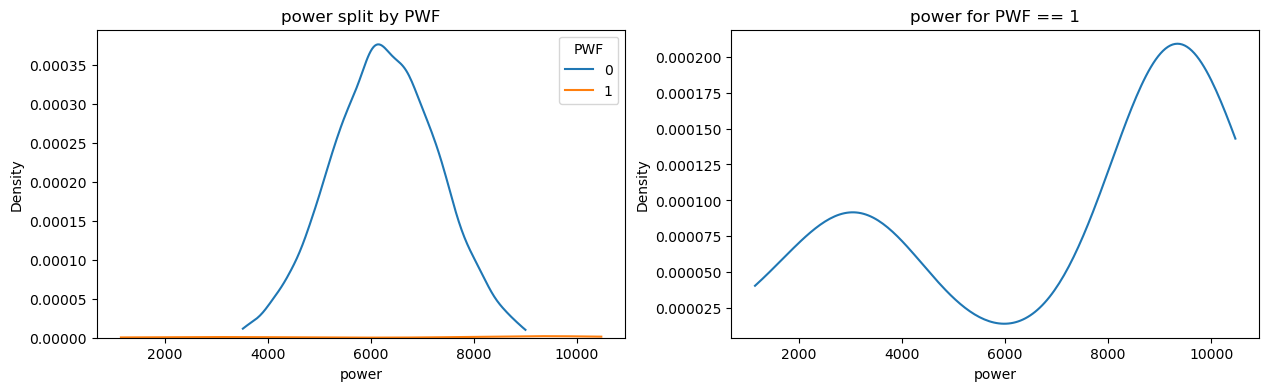

In [37]:
plot_numerical('power', split_col='PWF')

* Two peaks for PWF==1
* Below and above certain thresholds, the machine is always failing.

In [38]:
len(df.query("PWF==0 & power <= 3500")), len(df.query("PWF==0 & power >= 9000"))

(0, 0)

In [39]:
df['power_out_of_range'] = ((df.power <= 3500) | (df.power >= 9000)).astype('int')

### Cause of Overstrain Failure

Strain can be estimated as a product of tool wear and torque.

In [40]:
df['strain'] = df['Tool wear [min]'] * df['Torque [Nm]']

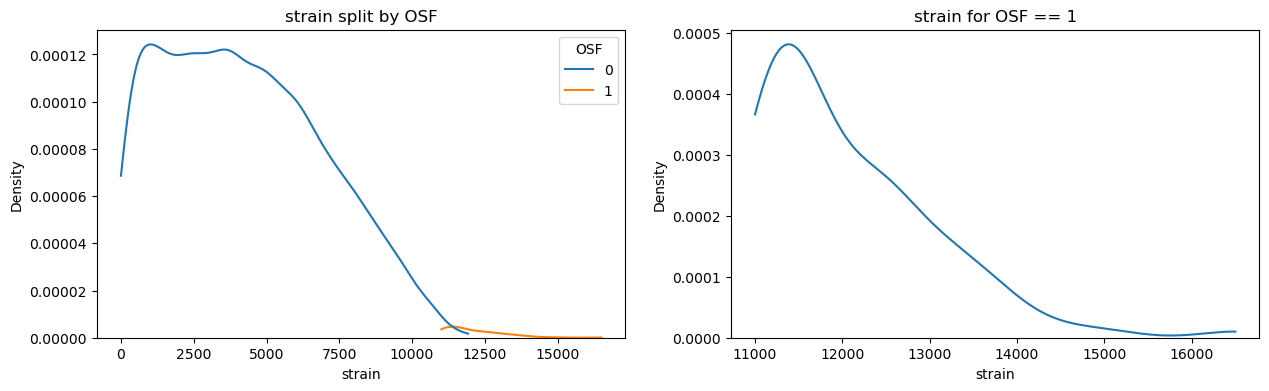

In [41]:
plot_numerical('strain', split_col='OSF')

* Below a certain threshold, machine is never failing -> around 11000
* Above a certain threshold, machine is always failing -> around 12000

In [42]:
len(df.query("OSF==1 & strain <= 11000")), len(df.query("OSF==1 & strain <= 11100"))

(0, 13)

In [43]:
len(df.query("OSF==0 & strain >= 12000")), len(df.query("OSF==0 & strain >= 11900"))

(0, 1)

In [44]:
df['strain_below_11k'] = (df.strain <=11000).astype('int')
df['strain_above_12k'] = (df.strain >=12000).astype('int')

# Feature selection

In [45]:
features = [f for f in df.columns if f not in ['UDI', 'Product ID', TARGET] + failure_types]

In [46]:
features

['Type',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'air_temp_celsius',
 'process_temp_celsius',
 'temp_diff',
 'temp_diff_above_threshold',
 'power',
 'power_out_of_range',
 'strain',
 'strain_below_11k',
 'strain_above_12k']

Some of these may be redundant or uninformative, in which case we will drop them.

In [47]:
data = df[features + [TARGET]]

In [48]:
categorical_features = [
    'Type', 
    'temp_diff_above_threshold', 
    'power_out_of_range', 
    'strain_below_11k', 
    'strain_above_12k'
]

numerical_features = [f for f in features if f not in categorical_features]

### Correlation

In [49]:
def plot_heatmap(df, size=8):
    plt.figure(figsize=(size, size * 0.75))
    sns.heatmap(
        data=df, 
        mask=np.triu(np.ones_like(df)),
        vmin=-1, vmax=1, center=0,
        annot=True, linewidths=0.1,
        fmt='.2f', annot_kws={'fontsize': 8})
    plt.show()

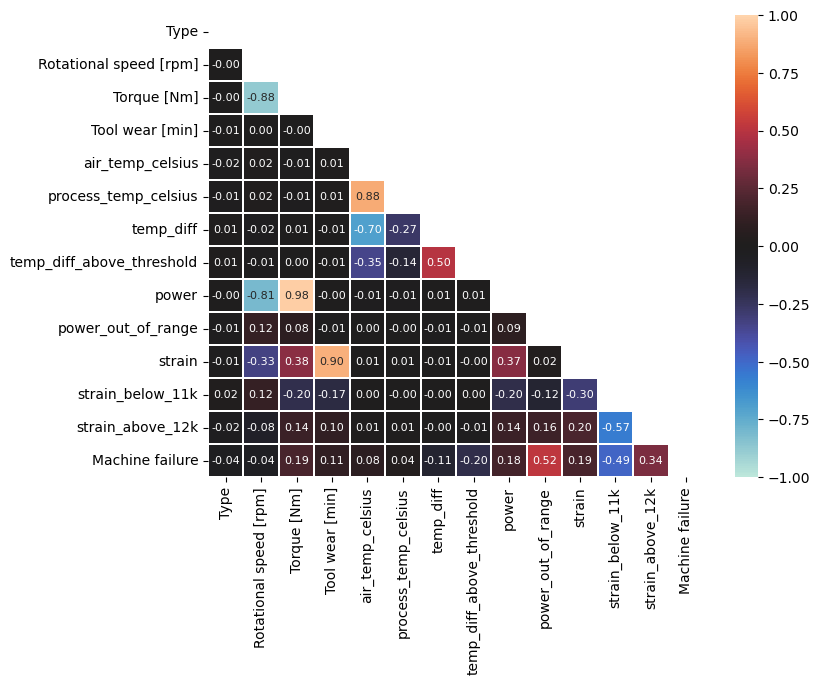

In [50]:
corr_df = data.corr(method='pearson')
plot_heatmap(corr_df)

### Chi-squared test (for categorical variables)

In [51]:
chi2_values, p_values = chi2(data[categorical_features], data[TARGET])

pd.DataFrame(
    data={
        'chi2-statistic': chi2_values, 
        'p-value': p_values,
        'accepted?': p_values < 0.05
    },
    index=categorical_features)

,chi2-statistic,p-value,accepted?
Type,12.140890,4.932822e-04,True
temp_diff_above_threshold,26.557493,2.558106e-07,True
power_out_of_range,2707.359882,0.000000e+00,True
strain_below_11k,29.551921,5.443868e-08,True
strain_above_12k,1168.439528,4.409063e-256,True


None of the categorical features are rejected based on univariate testing.

### ANOVA F-test

In [52]:
anova_values, p_values = f_classif(data[numerical_features], data[TARGET])

pd.DataFrame(
    data={
        'f-statistic': anova_values, 
        'p-value': p_values,
        'accepted?': p_values < 0.05
    },
    index=numerical_features)

,f-statistic,p-value,accepted?
Rotational speed [rpm],19.559690,9.853543e-06,True
Torque [Nm],379.867723,4.573805e-83,True
Tool wear [min],112.421077,3.976076e-26,True
air_temp_celsius,68.608385,1.354800e-16,True
process_temp_celsius,12.935260,3.240058e-04,True
temp_diff,126.265779,4.018489e-29,True
power,319.744392,2.044216e-70,True
strain,376.192914,2.698999e-82,True


None of the numerical features are rejected based on univariate testing.

### Mutual Information Score

In [53]:
cat_mask = [(f in categorical_features) for f in features]

mi_scores = mutual_info_classif(
    data[features], data[TARGET], 
    discrete_features=cat_mask, 
    random_state=0)

pd.DataFrame(
    data={'mi_score': mi_scores}, 
    index=features)

,mi_score
Type,0.000727
Rotational speed [rpm],0.038114
Torque [Nm],0.047194
Tool wear [min],0.011492
air_temp_celsius,0.005628
process_temp_celsius,0.004912
temp_diff,0.014595
temp_diff_above_threshold,0.011129
power,0.044413
power_out_of_range,0.033582


Based on a combination of correlation scores and mutual-information scores, the candidates for removal are:
* Type
* air_temp_celsius
* process_temp_celsius

However, they are not completely uninformative based on Chi-squared test and ANOVA F-test.

Additionally, *power* and *Torque [Nm]* have nearly perfect correlation, which makes one of them redundant.  
Torque has better scores and we have already used power to create the *power_out_of_range* feature, so we will treat power as the redundant feature.

In [54]:
reduced_features = [f for f in features if f not in 
                    ('Type', 'air_temp_celsius', 'process_temp_celsius', 'power')]

# Processed dataset

In [55]:
data.sample()

,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],air_temp_celsius,process_temp_celsius,temp_diff,temp_diff_above_threshold,power,power_out_of_range,strain,strain_below_11k,strain_above_12k,Machine failure
7758,0,1689,30.8,196,27.25,38.65,11.4,1,5447.660064,0,6036.8,1,0,0


We will create a holdout dataset which will be used for testing. None of the models will access this data.  
The remaining data will be used for model training and validation. 

To allow our models to learn in a stable manner and ensure proper evaluation, we must split the data such that there is an even distribution of classes.  

To achieve this, we will create a column by combining the 'Type' and 'Machine failure' and split the dataset using stratified train_test_split.

In [56]:
df['stratifier'] = df['Type'].astype('str') + ' - ' + df['Machine failure'].astype('str')
df[['Type', 'Machine failure', 'stratifier']].sample()

,Type,Machine failure,stratifier
6561,0,0,0 - 0


In [57]:
df['stratifier'].value_counts()

stratifier
0 - 0    5765
1 - 0    2914
2 - 0     982
0 - 1     235
1 - 1      83
2 - 1      21
Name: count, dtype: int64

Splitting our data:

In [58]:
train, test, _, _ = train_test_split(
    data, data[TARGET], 
    test_size=0.1,
    stratify=df['stratifier'],
    shuffle=True,
    random_state=0)

In [59]:
train.shape, test.shape

((9000, 14), (1000, 14))

In [60]:
train[TARGET].value_counts(normalize=True).rename('train'), test[TARGET].value_counts(normalize=True).rename('test')

(Machine failure
 0    0.966111
 1    0.033889
 Name: train, dtype: float64,
 Machine failure
 0    0.966
 1    0.034
 Name: test, dtype: float64)

In [61]:
train['Type'].value_counts(normalize=True).rename('train'), test['Type'].value_counts(normalize=True).rename('test')

(Type
 0    0.599889
 1    0.299778
 2    0.100333
 Name: train, dtype: float64,
 Type
 0    0.601
 1    0.299
 2    0.100
 Name: test, dtype: float64)

* We have successfully maintained proportions for *Type* and *Machine failure* in our train and test datasets. 
* Saving processed datasets in our 'Dataset' folder. They will be used for training and evaluating all our models.

In [62]:
PATH = '../Dataset/processed'

train.to_csv(f'{PATH}/train.csv', index=False)
test.to_csv(f'{PATH}/test.csv', index=False)